# Cell segmentation (full resolution) - (SMP U-Net with MobileNetV2 encoder)

In this notebook, I'll be training a U-Net in PyTorch using [SMP](https://smp.readthedocs.io/) on a GPU on the cell-seg dataset (adapted from [here](https://www.kaggle.com/c/data-science-bowl-2018)) at full resolution and dataset size. 

## 1. Data processing 

In [40]:
import pickle
in_file = open("../../data/cell_seg_full.pkl", 'rb')
d_set = pickle.load(in_file)

In [41]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
from torchvision import datasets
from torch.utils.data import DataLoader
from util import *

In [42]:
!pip install git+https://github.com/qubvel/segmentation_models.pytorch

  Cloning https://github.com/qubvel/segmentation_models.pytorch to /tmp/pip-req-build-5w0wgmsy
  Running command git clone --filter=blob:none -q https://github.com/qubvel/segmentation_models.pytorch /tmp/pip-req-build-5w0wgmsy
  Resolved https://github.com/qubvel/segmentation_models.pytorch to commit 740dab561ccf54a9ae4bb5bda3b8b18df3790025
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [44]:
import torch
import torchvision
from torch.utils.data import Dataset, TensorDataset

class GetDataset(Dataset):
    def __init__(self, data_set): # samples and labels are stored in tuples in data_set (list)
        self.data_distribution = data_set
    
    def __getitem__(self, index):
        sample = self.data_distribution[index][0]
        label = self.data_distribution[index][1]
        return (torch.tensor(sample, dtype=torch.float), torch.tensor(label, dtype=torch.float))
    
    def __len__(self):
        return len(self.data_distribution)

In [45]:
torch_set = GetDataset(d_set)

In [46]:
torch_set.__len__()

670

Visualize a sample image and mask:  

Image: 


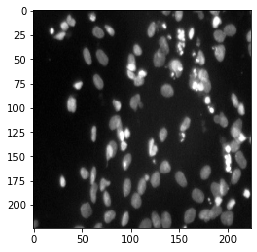

Map: 


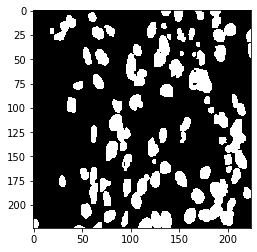

In [47]:
print("Image: ")
plot_tensor(torch_set[155][0], False)
print("Map: ")
plot_tensor(torch_set[155][1], False)

In [48]:
TRAIN_RATIO = 0.90  # 80/20 split (customize to your liking) 
train_size = int(TRAIN_RATIO * len(torch_set))
test_size = len(torch_set) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(torch_set, [train_size, test_size])

In [49]:
print("Training set length: ", train_dataset.__len__())
print("Test set length: ", test_dataset.__len__())

Training set length:  603
Test set length:  67


In [50]:
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=1) 
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=1)

In [51]:
for sample in trainloader:
    print("Image shape: ", sample[0].shape)
    print("Mask shape: ", sample[1].shape)
    break

Image shape:  torch.Size([1, 1, 224, 224])
Mask shape:  torch.Size([1, 1, 224, 224])


## 2. Build the model 

We will be using PyTorch SMP for this. 

In [70]:
import torch.nn as nn
import torch.nn.functional as F

In [71]:
# GPU set up 
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [72]:
import segmentation_models_pytorch as smp

model = smp.Unet(
    encoder_name="mobilenet_v2",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=1,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=1,                      # model output channels (number of classes in your dataset)
)

In [73]:
model.to(device)

Unet(
  (encoder): MobileNetV2Encoder(
    (features): Sequential(
      (0): ConvNormActivation(
        (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): ConvNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): ConvNormActivation(
            (0): Conv2d(16, 96, kernel_size=(1, 1), 

In [74]:
def get_model_size(net):
    """
    Function that calculates PyTorch model size. 
    Returns and prints. 
    Returns (num params, model size in MB). 
    """
    
    # taken from 
    # https://stackoverflow.com/questions/49201236/check-the-total-number-of-parameters-in-a-pytorch-model
    total_params = sum(p.numel() for p in net.parameters())
    
    # taken from 
    # https://discuss.pytorch.org/t/finding-model-size/130275/2 
    param_size = 0
    for param in net.parameters():
        param_size += param.nelement() * param.element_size()
    buffer_size = 0
    for buffer in net.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()

    size_all_mb = (param_size + buffer_size) / 1024**2
    
    print("Total number of parameters: ", total_params)
    print('model size: {:.3f}MB'.format(size_all_mb))

    return total_params, size_all_mb

In [75]:
get_model_size(model)

Total number of parameters:  6628369
model size: 25.423MB


(6628369, 25.423389434814453)

Quick little function to binarize the mask 

In [76]:
def binarize_mask(mask):
    return (mask>0.5).float()

#### Sample plotting: 

Data shape:  torch.Size([1, 1, 224, 224])
Mask shape:  torch.Size([1, 1, 224, 224])
Pred shape:  torch.Size([1, 1, 224, 224])

 Image: 


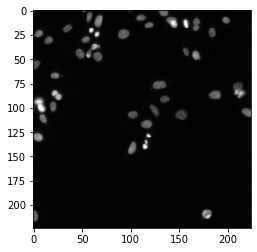

Ground truth mask: 


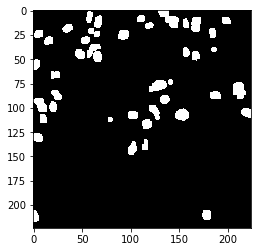

Raw prediction map: 


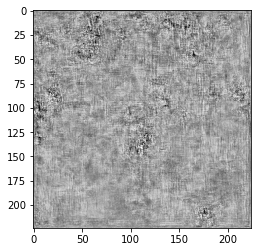

Binary prediction map: 


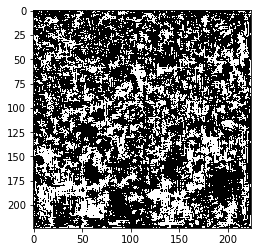

In [79]:
for elem in trainloader:
    data = elem[0].to(device)
    mask = elem[1].to(device)
    print("Data shape: ", data.shape)
    print("Mask shape: ", mask.shape)
    pred_map = model(data)
    print("Pred shape: ", pred_map.shape)
    bin_pred = binarize_mask(pred_map)
    
    # plotting  
    print("\n Image: ")
    plot_tensor(data.cpu(), False)
    print("Ground truth mask: ")
    plot_tensor(mask.cpu(), False)
    print("Raw prediction map: ")
    plot_tensor(pred_map.detach().cpu(), False)
    print("Binary prediction map: ")
    plot_tensor(bin_pred.detach().cpu(), False)
    break

This is what the model is predicting on pre-trained weights. Let us train these a bit more and see if we can get better results! 

## 3. Train 

In [81]:
import torch.optim as optim
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [82]:
loss = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)

In [85]:
%%time
# training loop 
import time

enum = 0
elosses = []
NUM_EPOCHS = 3
start_time = time.time()
epoch_time = time.time()

for epoch in range(NUM_EPOCHS):
    enum += 1
    running_loss = 0.0
    
    for data in trainloader:
        # 1. get data 
        inputs = data[0].to(device)
        masks = data[1].to(device)
        
        # 2. zero out grads 
        optimizer.zero_grad()
        
        # 3. forward + backward + optimize
        logits = model(inputs)
        loss_val = loss(logits, masks)
        loss_val.backward()
        optimizer.step()
        
        running_loss += loss_val
    
    # loss stats 
    epoch_loss = (running_loss/len(trainloader)).cpu().detach().numpy()
    elosses.append(epoch_loss)
    print('Loss epoch {}: '.format(enum), epoch_loss)
    
    # timing 
    new_time = time.time()
    print("Total time (s): ", int(new_time - start_time))
    print("Epoch time (s): ", int(new_time - epoch_time))
    print("-------------------------")
    epoch_time = time.time()


Loss epoch 1:  0.6580953
Total time (s):  23
Epoch time (s):  23
-------------------------
Loss epoch 2:  0.34492433
Total time (s):  47
Epoch time (s):  23
-------------------------
Loss epoch 3:  0.21528119
Total time (s):  72
Epoch time (s):  24
-------------------------
CPU times: user 9min 3s, sys: 33.6 s, total: 9min 36s
Wall time: 1min 12s


In [87]:
torch.save(model.state_dict(), "saved_models/fullsegsmp_1.pth")  # use .pth extension 

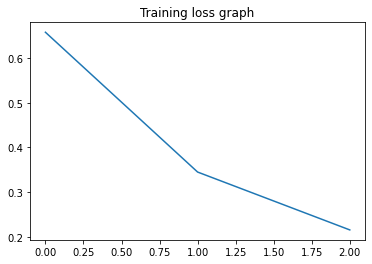

In [89]:
import matplotlib.pyplot as plt
plt.plot(elosses)
plt.title("Training loss graph")
plt.show()

## 4. Predictions 


Let us see how we did!

In [130]:
iou_scores = 0
f1_scores = 0
f2_scores = 0
accuracies = 0
recalls = 0

with torch.no_grad():
    for elem in testloader:
        data = elem[0].to(device)
        mask = elem[1].to(device).long()
        pred_map = model(data).long()
        tp, fp, fn, tn = smp.metrics.get_stats(pred_map, mask, mode='binary', threshold=0.5)

        iou_score = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
        f1_score = smp.metrics.f1_score(tp, fp, fn, tn, reduction="micro")
        f2_score = smp.metrics.fbeta_score(tp, fp, fn, tn, beta=2, reduction="micro")
        accuracy = smp.metrics.accuracy(tp, fp, fn, tn, reduction="macro")
        recall = smp.metrics.recall(tp, fp, fn, tn, reduction="micro-imagewise")
        
        iou_scores += iou_score
        f1_scores += f1_score
        f2_scores += f2_score
        accuracies += accuracy
        recalls += recall

print("Test set statistics: ")
print("----------------------")
print("IOU: ", round((iou_scores/len(testloader)).item(), 3))
print("f1: ", round((f1_scores/len(testloader)).item(), 3))
print("f2: ", round((f2_scores/len(testloader)).item(), 3))
print("accuracy: ", round((accuracies/len(testloader)).item(), 3))
print("recall: ", round((recalls/len(testloader)).item(), 3))

Test set statistics: 
----------------------
IOU:  0.698
f1:  0.807
f2:  0.794
accuracy:  0.935
recall:  0.804


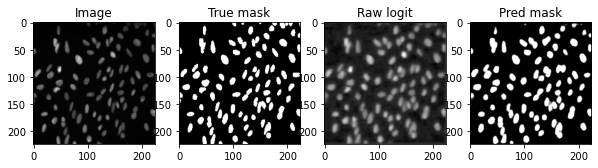

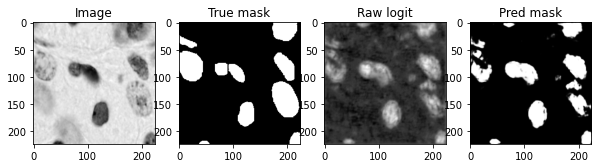

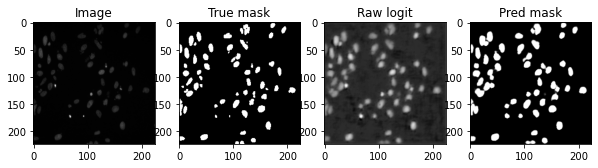

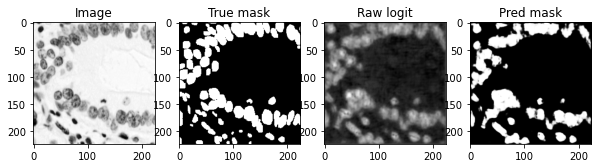

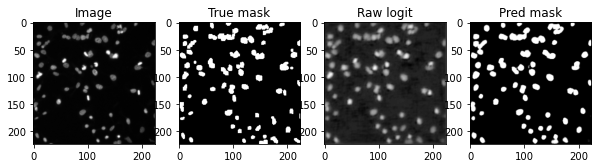

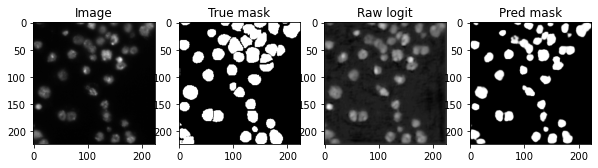

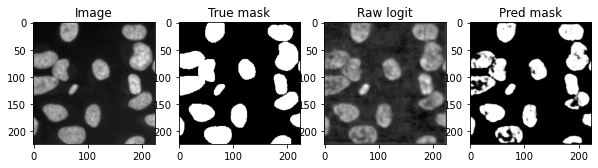

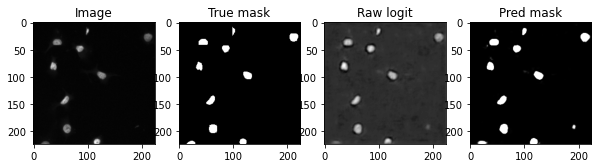

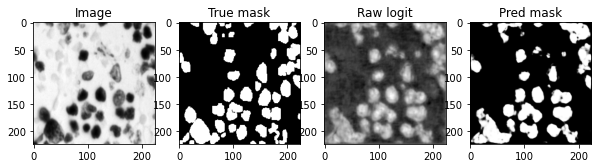

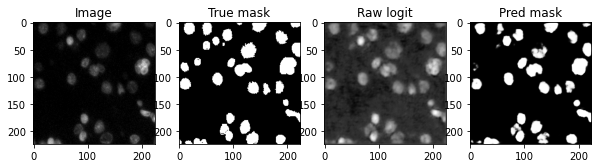

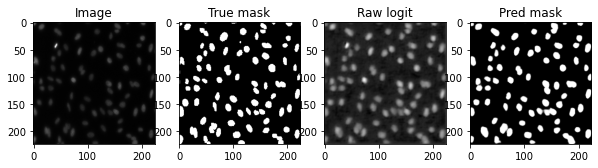

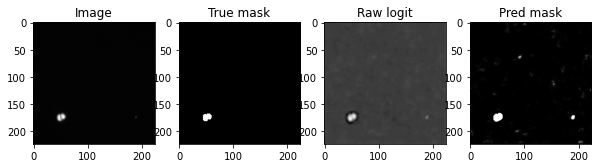

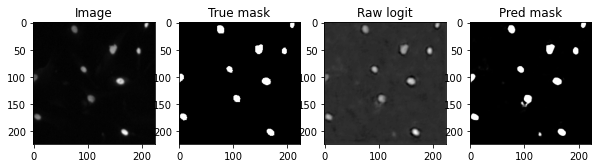

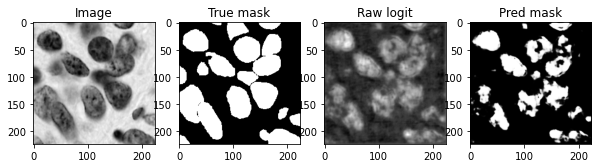

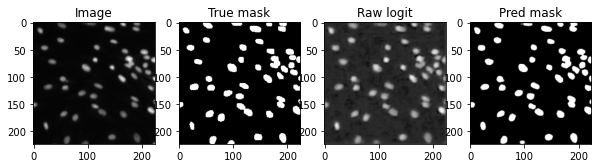

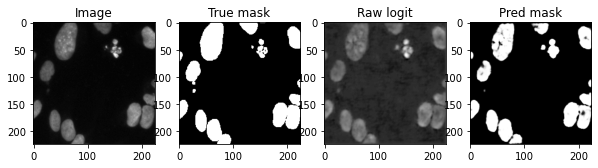

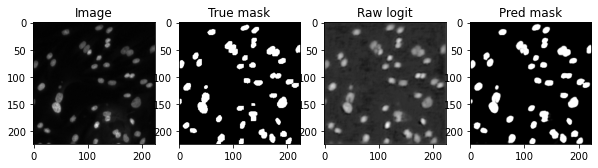

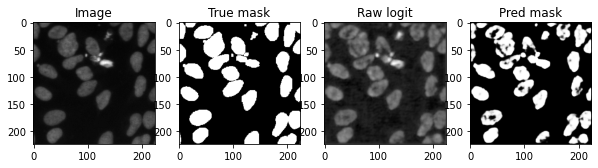

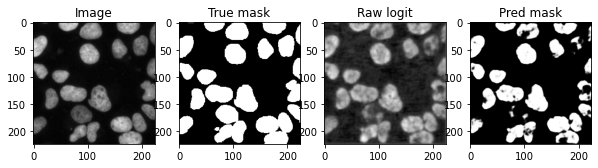

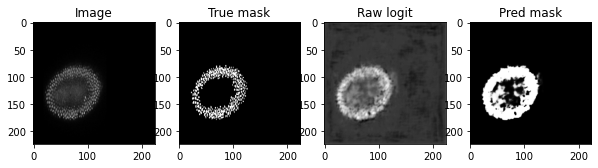

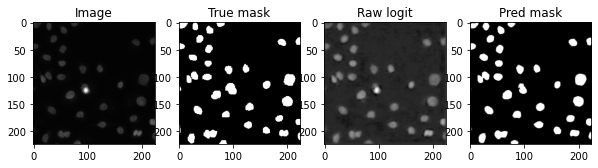

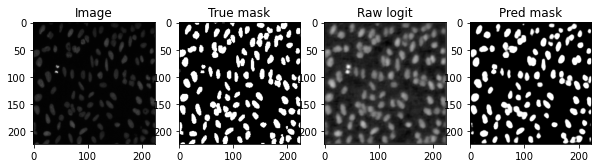

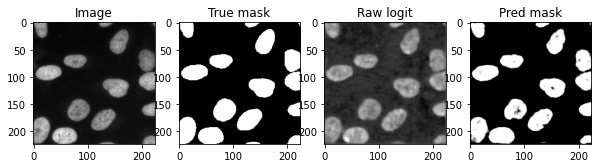

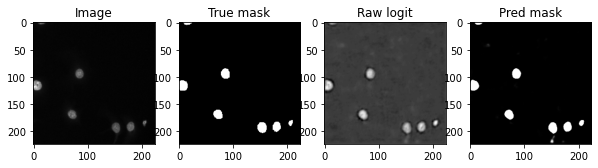

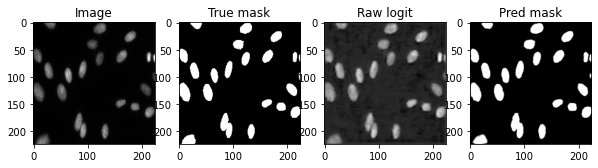

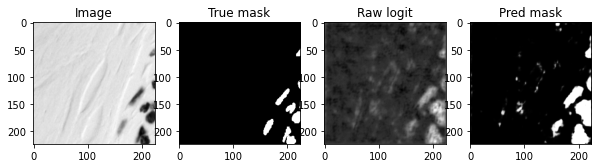

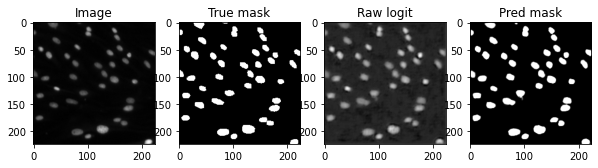

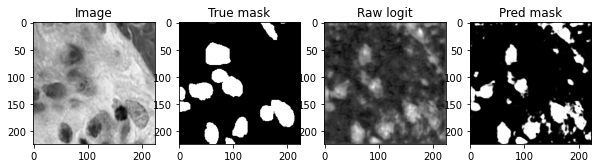

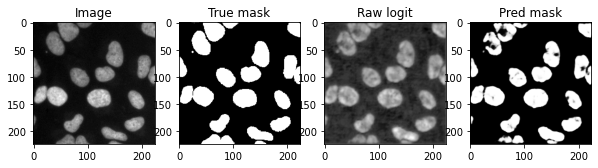

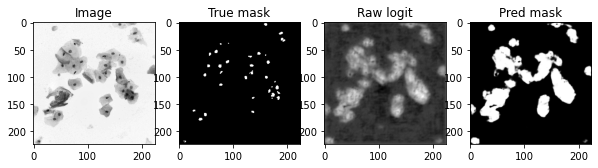

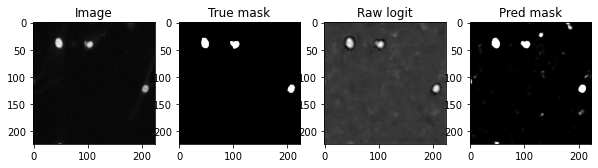

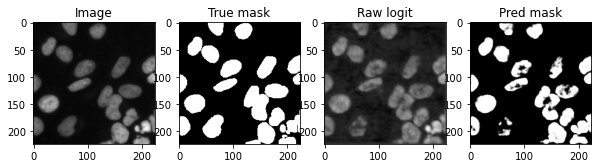

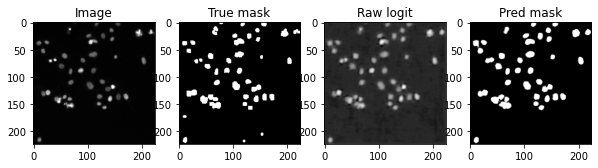

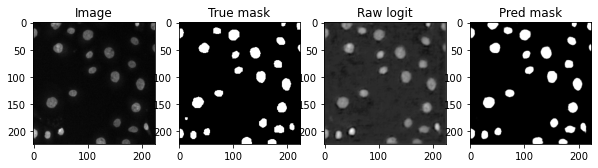

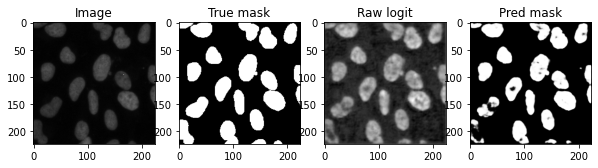

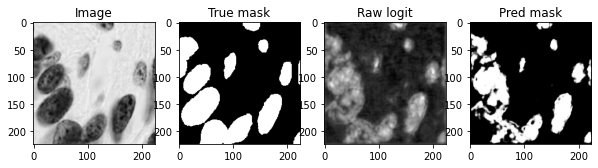

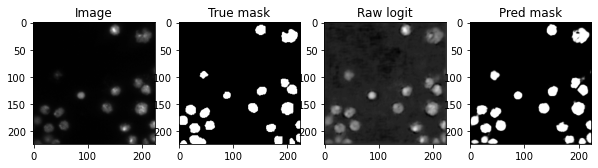

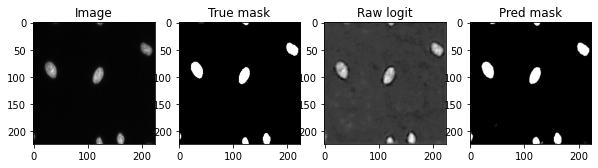

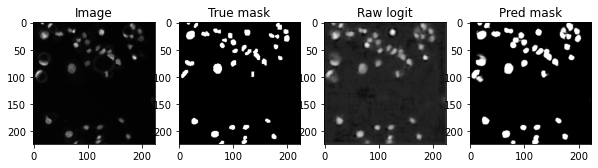

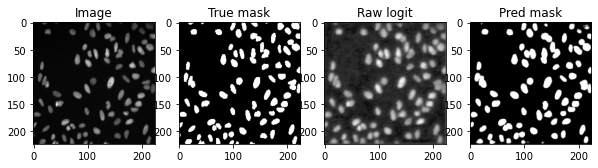

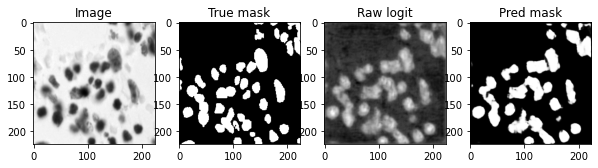

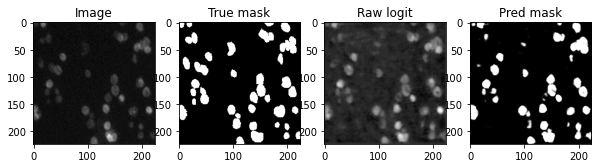

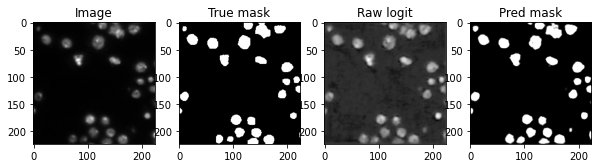

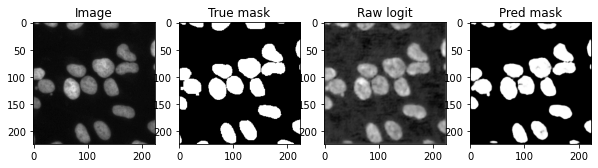

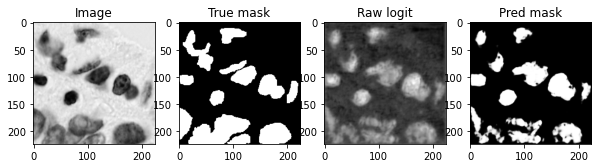

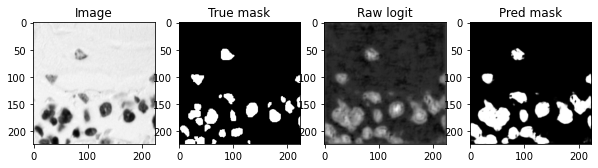

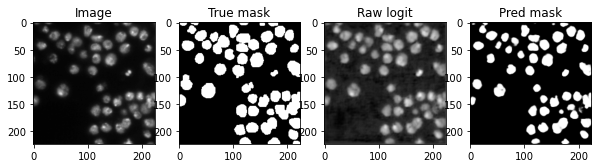

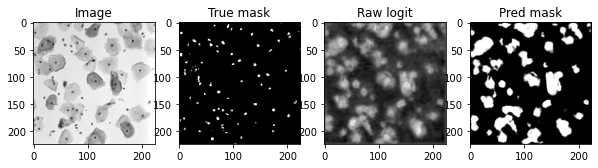

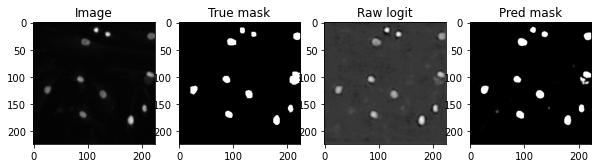

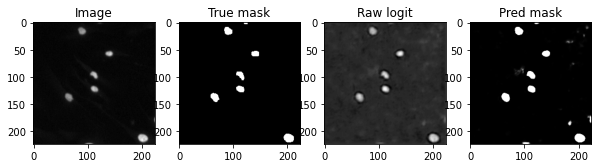

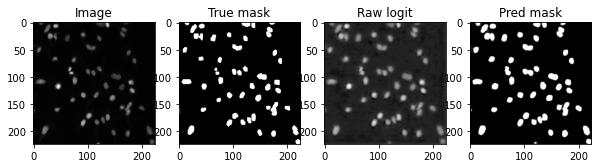

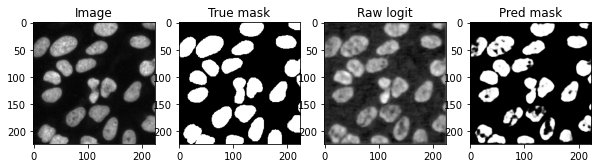

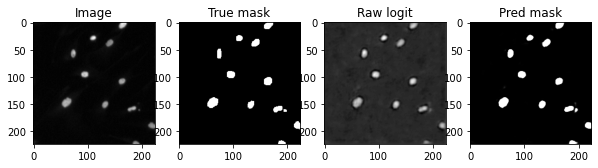

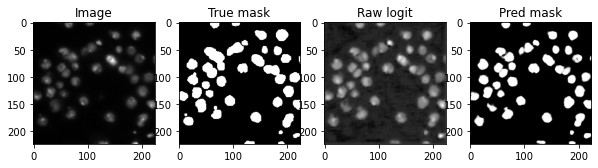

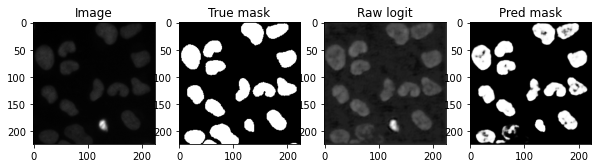

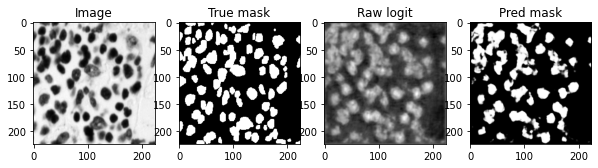

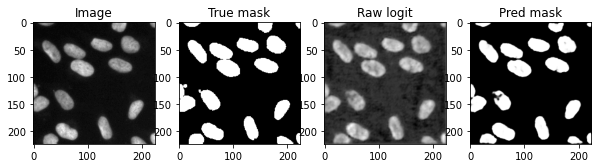

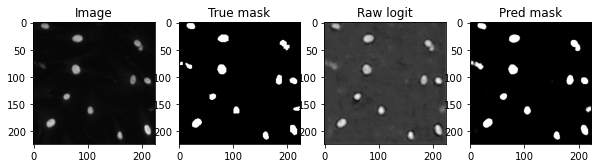

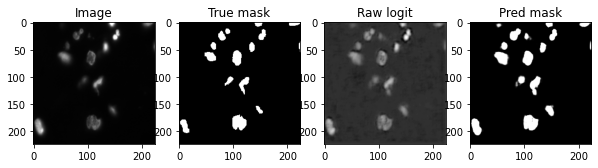

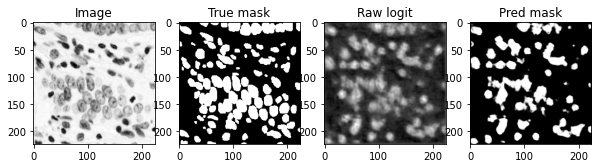

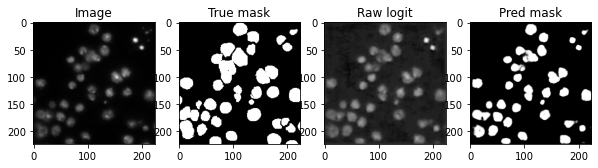

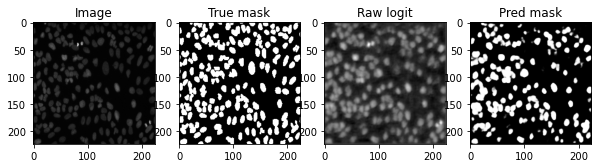

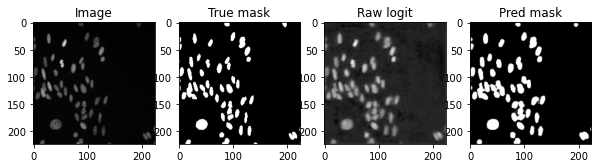

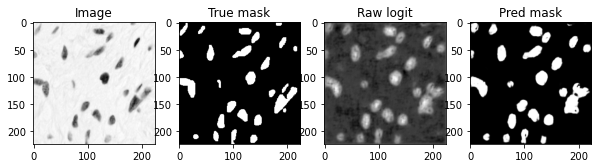

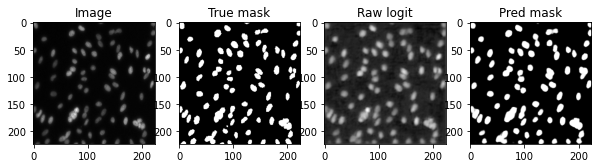

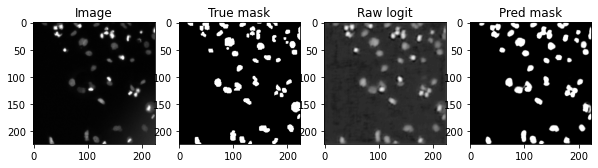

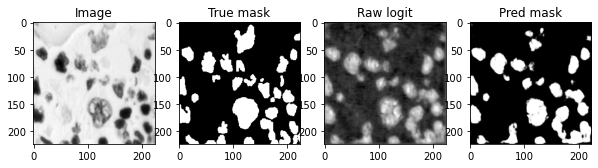

In [131]:
with torch.no_grad():
    for elem in testloader:
        data = elem[0].to(device)
        mask = elem[1].to(device)
    #     print("Data shape: ", data.shape)
    #     print("Mask shape: ", mask.shape)
        pred_map = model(data)
    #     print("Pred shape: ", pred_map.shape)
        # bin_pred = binarize_mask(pred_map)
        bin_pred = pred_map.sigmoid()
        
        # plotting 
        plt.figure(figsize=(10, 5))
        
        plt.subplot(1, 4, 1)
        plt.imshow(np.squeeze(data.cpu().numpy()), cmap='gray')
        plt.title("Image")
        
        plt.subplot(1, 4, 2)
        plt.imshow(np.squeeze(mask.cpu().numpy()), cmap='gray')
        plt.title("True mask")
        
        plt.subplot(1, 4, 3)
        plt.imshow(np.squeeze(pred_map.detach().cpu().numpy()), cmap='gray')
        plt.title("Raw logit")
        
        plt.subplot(1, 4, 4)
        plt.imshow(np.squeeze(bin_pred.detach().cpu().numpy()), cmap='gray')
        plt.title("Pred mask")
        
        plt.show()
        